**Data exploration mode: ON!**
Let's dive into the dataset with our trusty packages :)

In [191]:
import os # only for accessing files - not for analysis 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Loading and Description

In [192]:
# Reading the factory test data file and converting it to dataframe format
file_path = os.path.join(os.getcwd(), 'factory_test_data.csv')
df = pd.read_csv(file_path)

When initially exploring a dataset, I approach it by taking a glance at its contents to gain insights into the dataset's structure and decide what data processing steps are necessary for further analysis and preparation.
For example:

In [193]:
df.head()

,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5
0,1491,18,16.8,14,13.33,12,11.12,9,8.33
1,1491,[],[],[],[],[],[],[],[]
2,2004,18,17.94,14,13.99,12,11.72,9,8.65
3,1493,[],[],[],[],[],[],[],[]
4,1497,18,18,14,13.59,12,12.91,9,7.82


Each sample in the dataset contains 5 features: Y1,..,Y5 which are dependent variables. Y2,..,Y5 correspond to X2,..,X5 which are independent variables and Y1 is not corresponding to any X variable. My assumption is that X variables reffer to the expected (desired) value of parameter Y. for further analysis, i will perform necessary preprocessing on the data. 

### Step 2: Preprocessing the data

In [194]:
# Replace '[]' in all cells of the DataFrame with NaN
df = df.applymap(lambda x: x if x != '[]' else pd.NA)
# Drop rows containing any NaN values (rows with '[]' values)
df = df.dropna().reset_index(drop=True)
# Convert values in df from str to float
df = df.astype(float)
# Check that the preprocessing was done correctly 
df.head()

,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5
0,1491.0,18.0,16.80,14.0,13.33,12.0,11.12,9.0,8.33
1,2004.0,18.0,17.94,14.0,13.99,12.0,11.72,9.0,8.65
2,1497.0,18.0,18.00,14.0,13.59,12.0,12.91,9.0,7.82
3,1498.0,18.0,7.87,14.0,13.52,12.0,11.51,9.0,8.29
4,1492.0,18.0,20.23,14.0,13.41,12.0,9.73,9.0,8.58


 Now that the data is clean and ready for manipulation, let's dive deeper into our dataset to gain a better understanding of it. 
 
### Step 3: Data Visualization and Explanation

To gain a better understanding of how to handle the parameters, it is important to visualize their distribution since there is no available description for each parameter. 

* Visualizing the distributions can help uncover patterns and make informed decisions on how to process them effectively.

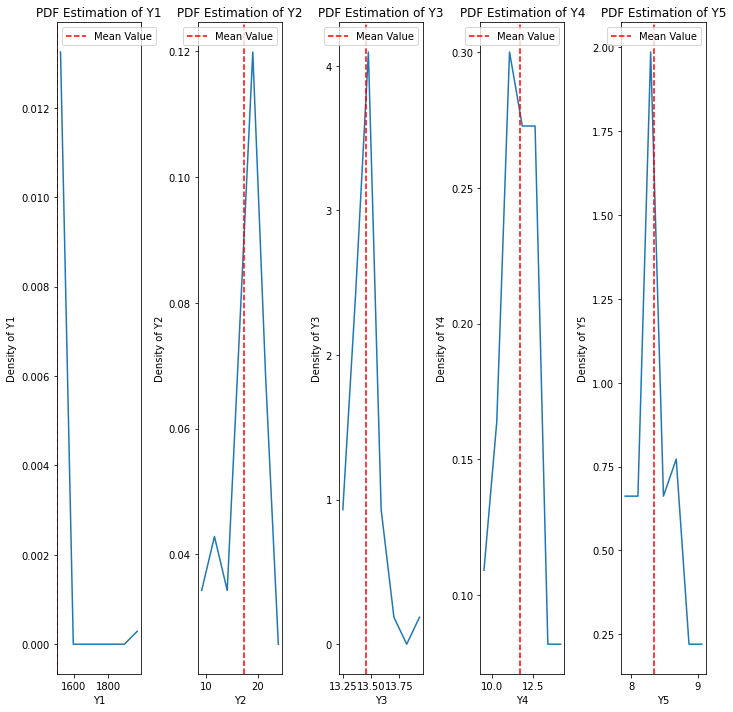

In [195]:
params = ['Y1', 'Y2', 'Y3', 'Y4', 'Y5']

fig, axes = plt.subplots(1, 5, figsize=(10, 10))

for i, param in enumerate(params):
    # Extract the values of the random variable as a NumPy array
    data = df[param].values

    # Calculate KDE 
    density, bins = np.histogram(data, bins=7, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    # Calculate the mean value for the parameter
    mean_value = np.mean(data)

    # Plot the estimated PDF
    axes[i].plot(bin_centers, density)
    axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean Value')
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Density of {}'.format(param))
    axes[i].set_title('PDF Estimation of {}'.format(param))
    axes[i].legend()

# Adjust spacing between the subplots
plt.tight_layout()
# Display the plots
plt.show()

* the observation that all the distributions appear approximately Gaussian is interesting and can really help moving forward with the analysis. The fact that the data exhibits Gaussian-like distributions suggests that certain statistical properties are applicable (such as the central limit theorom)

The following plots were only made for dependent variables, assuming that their corresponding X's represent the expected (desired value), we can look for anomalies in our data and the overall distribution of each parameter around the expected value: 

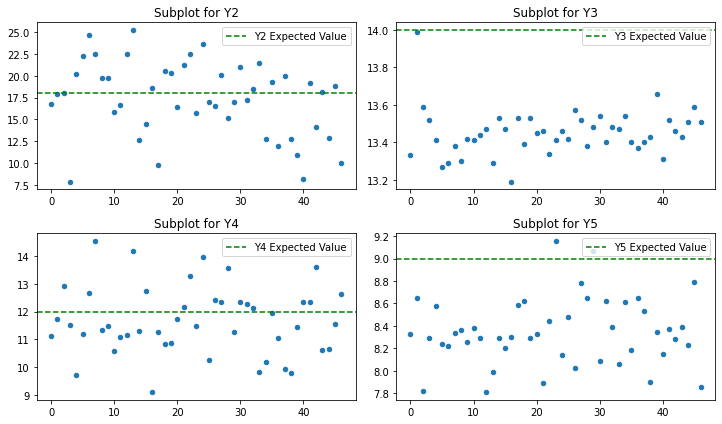

In [196]:
# Create a figure with subplots
plt.figure(figsize=(10, 6))
params = ['Y2', 'Y3', 'Y4', 'Y5']
for i, val in enumerate(params):
    plt.subplot(2, 2, i+1)
    plt.axhline(y=df.loc[0, expected[i]], color='green', linestyle='--', label='%s Expected Value' % val)
    plt.scatter(range(len(df.index)), df[val], s=20)  # Set the size of the circles to 20
    plt.legend(loc='upper right')  # Move the legend to the upper right corner
    plt.title(f'Subplot for {val}')

plt.tight_layout()
plt.show()

### Step 4: Data Exploration 

Now there is a new dataset of devices, containing 3 additional devices and the task is to rank these devices based on their probability of belonging to the sample group. first, I'll upload the new data and preprocess it. 

In [197]:
# Reading the new devices dataset and converting it to dataframe
new_devices_file_path = os.path.join(os.getcwd(), 'new_devices.csv')
new_devices_df = pd.read_csv(new_devices_file_path)

# Replace '[]' in all cells of the DataFrame with NaN
df = df.applymap(lambda x: x if x != '[]' else pd.NA)
# Drop rows containing any NaN values (rows with '[]' values)
df = df.dropna().reset_index(drop=True)
# Convert values in df from str to float
new_devices_df = new_devices_df.astype(float)

The way I approached this task was by thinking about each parameter (Y1,..,Y5) as a random variable, and the combination of those variables as a random vector. 

Using the visualization I performed, it was easier for me to establish that it is reasonable to assume that each variable (parameter) is distributed according to a  Gaussian (normal) distribution, or a multivariate Gaussian distribution for a random vector. 

This helps me assess the probability of new devices belonging to the sample group by considering the joint behavior of all their parameters and accounting for correlations among them. let's code it first and then will touch on the math behind it: 

In [198]:
expected = ['X2', 'X3', 'X4', 'X5']
parameters = ['Y1', 'Y2', 'Y3', 'Y4', 'Y5']
expected_values = {'Y2': 18, 'Y3': 14, 'Y4': 12, 'Y5': 9}

# calculate the mean and cov of the sample group parameters
sample_mean_vector = df[parameters].mean()
sample_cov_vector = df[parameters].cov()

def calculate_probability(new_data_row, sample_mean, sample_cov):
    """
    :new_data_row: pd data series that contains a sample of a new device
    :sample_mean: float the mean of the sample group parameters
    :sample_cov: float the cov of the sample group parameters
    """
    # subtracting the vector of observed values (new device) for the random vector Y
    diff = new_data_row - sample_mean
    # calculating the exponent according to the formula
    exponent = -0.5 * np.dot(np.dot(diff.T, np.linalg.inv(sample_cov)), diff)
    # calculating the PDF of the multivariate Gaussian distribution
    probability = np.exp(exponent) / ((2 * np.pi)**(len(sample_mean) / 2) * np.sqrt(np.linalg.det(sample_cov)))
    return probability

The probability density function (PDF) of the multivariate Gaussian distribution is given by:
$$
 f_X(x) = \frac{1}{(2\pi)^{d/2} \sqrt{\det(\Sigma)}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$ 
where:
- $x$ (new device vector) is the vector of observed values (features) for the random vector $X$.
- $\mu$ is the mean vector of $(X)$, which is a $d$-dimensional vector representing the expected values for each feature in $X$.
- $\Sigma$ is the $d \times d$ covariance matrix of $X$, which represents the covariance between all pairs of features in $X$.
- $\Sigma^{-1}$ is the inverse of the covariance matrix.
- $\det(\Sigma)$ is the determinant of the covariance matrix.

Note that the probability is not scaled just yet, we will deal with it now:

In [199]:
# Calculate the probability for each new device in the 'new_data' DataFrame
new_devices_df_features = new_devices_df[parameters].values
new_devices_df['Probability'] = [calculate_probability(row, sample_mean_vector, sample_cov_vector) for row in new_devices_df_features]

# Normalize the probabilities for the new devices to ensure they sum up to 1
new_devices_df['Probability'] = new_devices_df['Probability'] / new_devices_df['Probability'].sum()
new_devices_df.head()

,ID,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,Probability
0,1.0,1557.0,18.0,16.15,14.0,13.55,12.0,11.28,9.0,8.33,0.316298
1,2.0,1497.0,18.0,18.31,14.0,13.44,12.0,11.65,9.0,8.34,0.468240
2,3.0,1495.0,18.0,17.48,14.0,13.39,12.0,11.52,9.0,8.03,0.215462


To conclude, graphing the results: 

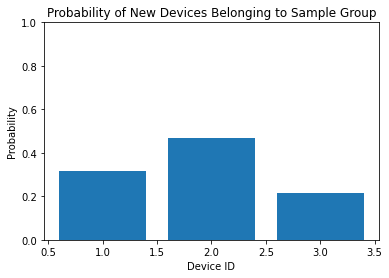

In [200]:
# Plot the results
plt.bar(new_devices_df['ID'], new_devices_df['Probability'])
plt.xlabel('Device ID')
plt.ylabel('Probability')
plt.title('Probability of New Devices Belonging to Sample Group')
plt.ylim(0, 1)  # Set the y-axis limit to 0 and 1 to show probabilities between 0 and 1
plt.show()

The first ranked device is #2, the second ranked is #1 and the last ranked is device #3

### Step 5: Bonus

The task in this section is to suggest a method which determines which of the devices (in both the sample and new group) are functional and which aren't. There is no difference between the two datasets so we can join them: 

In [201]:
new_devices_df = new_devices_df.drop(['Probability', 'ID'], axis=1).reset_index(drop=True)
devices_df = pd.concat([df, new_devices_df])

#### Mehod 1: Z-score

The z-score is a statistical measure used to standardize data points by expressing their deviation from the mean in terms of standard deviations. 

$z = (x - μ) / σ$

* Z-scores fit the task of classifying samples based on their parameter values in this context because they provide a standardized and uniform scale to compare data points.
* the function allows customization of the threshold for classification (z_score_threshold), providing flexibility to adjust the sensitivity of the classification process.
* there is an underlying assumption of normality in parameter distributions

In [202]:
def classify_samples_by_z_score(df, expected_values, z_score_threshold=2.0):
    """
    Classify samples in a DataFrame based on z-scores.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the samples to classify.
        expected_values (dict): A dictionary mapping parameter names to their expected values.
        z_score_threshold (float, optional): The z-score threshold for classifying samples. 
                                             Default is 2.0.

    Returns:
        pd.Series: A Series with classification results for each sample ('Pass' or 'Fail').
    """
    z_scores = {}
    for param_name, expected_value in expected_values.items():
        param_values = df[param_name]
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        z_scores[param_name] = (param_values - mean) / std_dev

    results = []
    for index, row in df.iterrows():
        row_z_scores = np.array([z_scores[param_name][index] for param_name in expected_values.keys()])
        sample_result = np.all(np.abs(row_z_scores) <= z_score_threshold)
        results.append('Pass' if sample_result else 'Fail')
    return pd.Series(results)

#### Method 2: classifying by percentiles

* classifying by percentiles is a method that compares the sample's parameter values with the lower and upper percentiles of the expected values. 
* It uses percentiles to determine whether a sample falls within the specified range (defined by lower_percentile and upper_percentile) to classify it as 'Pass'; otherwise, it is classified as 'Fail'.
* This approach is non-parametric and flexible, making it suitable for datasets with potential outliers.

In [203]:
def classify_samples_by_percentile(df, expected_values, lower_percentile=5, upper_percentile=95):
    """
    Classify samples in a DataFrame based on percentiles.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the samples to classify.
        expected_values (dict): A dictionary mapping parameter names to their expected values.
        lower_percentile (int, optional): The lower percentile threshold for classifying samples. 
                                         Default is 5.
        upper_percentile (int, optional): The upper percentile threshold for classifying samples. 
                                         Default is 95.

    Returns:
        pd.Series: A Series with classification results for each sample ('Pass' or 'Fail').
    """
    lower_percentiles = df.loc[:, parameters].quantile(lower_percentile / 100)
    upper_percentiles = df.loc[:, parameters].quantile(upper_percentile / 100)

    results = []
    for index, row in df.iterrows():
        sample_result = all(lower_percentiles[param_name] <= row[param_name] <= upper_percentiles[param_name]
                        for param_name in expected_values.keys())
        results.append('Pass' if sample_result else 'Fail')
    return pd.Series(results)

In [204]:
devices_df['z_score_res'] = classify_samples_by_z_score(devices_df, expected_values, z_score_threshold=2.0)
devices_df['precentile_res'] = classify_samples_by_percentile(devices_df, expected_values, lower_percentile=5, upper_percentile=95)
devices_df.sample(n=15)

,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,z_score_res,precentile_res
41,1491.0,18.0,19.13,14.0,13.52,12.0,12.35,9.0,8.37,Pass,Pass
30,1494.0,18.0,21.03,14.0,13.54,12.0,12.36,9.0,8.09,Pass,Pass
4,1492.0,18.0,20.23,14.0,13.41,12.0,9.73,9.0,8.58,Pass,Fail
2,1497.0,18.0,18.00,14.0,13.59,12.0,12.91,9.0,7.82,Pass,Fail
32,1503.0,18.0,18.53,14.0,13.48,12.0,12.13,9.0,8.39,Pass,Pass
2,1495.0,18.0,17.48,14.0,13.39,12.0,11.52,9.0,8.03,Pass,Fail
23,1491.0,18.0,15.73,14.0,13.41,12.0,11.49,9.0,9.16,Fail,Fail
31,1495.0,18.0,17.18,14.0,13.40,12.0,12.29,9.0,8.62,Pass,Pass
12,1493.0,18.0,22.51,14.0,13.47,12.0,11.15,9.0,7.81,Pass,Fail
27,1488.0,18.0,20.13,14.0,13.52,12.0,12.35,9.0,8.78,Pass,Pass
